Extracting Features from Kaggle Dataset to test it on PCA and KNN

In [2]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")  # Labels

print(X.shape[1])

4000


In [5]:
#PCA

def standardise_data(dataset):
  mean=np.mean(dataset,axis=0) #Mean
  std_dev=np.std(dataset,axis=0) #Standard Deviation
  std_data=(dataset-mean)/std_dev #Standardised Data

  return std_data

#Covariance matrix

def covariance_matrix(dataset):
  m=dataset.shape[0] #no of samples in the dataset
  cov_matrix=np.dot(dataset.T,dataset)/(m-1) #Covariance Matrix

  return cov_matrix

#Eigenvalues and Eigenvectors

def eigenvalues_eigenvectors(cov_matrix):
  eigenvalues,eigenvectors=np.linalg.eig(cov_matrix)

  return eigenvalues,eigenvectors

def sort_eigenpairs(eigenvalues,eigenvectors):
  sorted_indices=np.argsort(eigenvalues)[::-1] #Sorting in descending order
  sorted_eigenvalues=eigenvalues[sorted_indices]
  sorted_eigenvectors=eigenvectors[:,sorted_indices]

  return sorted_eigenvalues,sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
  W=eigenvectors[:,:top_n]

  projected_data=np.dot(X,W)

  return projected_data

In [6]:
#KNN

def calDist(x,y,metric):
    """Compute the distance (either euclidean or manhattan)

    """
    # YOUR CODE HERE
    # order=len(x)     #No of dimensions

    x,y=np.array(x), np.array(y)
    if(metric=='euclidean'):
      return round(math.sqrt(np.sum((x-y)**2)), 2)      #Rounding off to 2 decimal places as instructed below.
    elif(metric=="manhattan"):
      return round(np.sum(np.abs(x - y)), 2)    #Rounding off to 2 decimal places as instructed below.

def knn_predict(X_train, y_train, X_test, k=5, metric='euclidean'):
    predictions = []
    for test_point in X_test:
        distances = [calDist(test_point, train_point, metric) for train_point in X_train]
        k_neighbors = np.argsort(distances)[:k]
        k_labels = [y_train[i] for i in k_neighbors]
        predictions.append(Counter(k_labels).most_common(1)[0][0])
    return np.array(predictions)



Best Test Accuracy: 79.08% at top_n = 17
Train Accuracy: 89.58%
Validation Accuracy: 76.98%


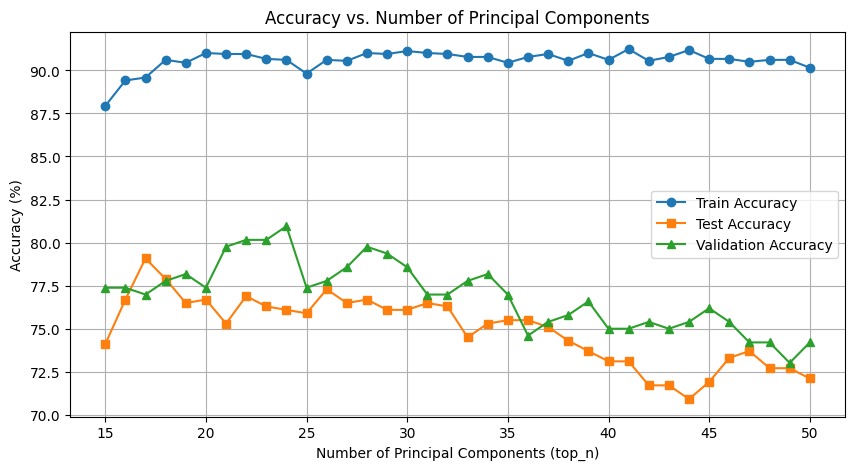

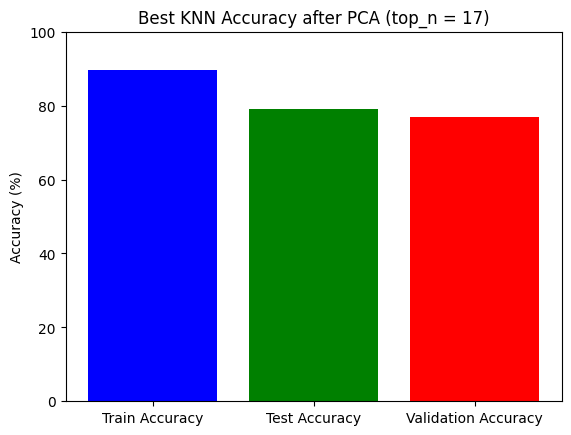

In [9]:
# Standardizing Data
X_std = standardise_data(X)

# Compute Eigenvectors
cov_matrix = covariance_matrix(X_std)
eigenvalues, eigenvectors = eigenvalues_eigenvectors(cov_matrix)
eigenvalues, eigenvectors = sort_eigenpairs(eigenvalues, eigenvectors)

# Performing PCA with varying top_n
train_accuracies = []
test_accuracies = []
val_accuracies = []
top_n_values = range(15, 51)

for top_n in top_n_values:
    X_pca = project_dataset_to_new_plane(X_std, eigenvectors, top_n)

    # Splitting data (70-20-10 Train-Test-Val Split)
    X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    # Running KNN
    k = 5
    metric = 'euclidean'
    y_train_pred = knn_predict(X_train, y_train, X_train, k, metric)
    y_test_pred = knn_predict(X_train, y_train, X_test, k, metric)
    y_val_pred = knn_predict(X_train, y_train, X_val, k, metric)

    # Accuracy Calculation
    train_accuracy = np.mean(y_train_pred == y_train) * 100
    test_accuracy = np.mean(y_test_pred == y_test) * 100
    val_accuracy = np.mean(y_val_pred == y_val) * 100

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

# Find max test accuracy and corresponding top_n
max_test_accuracy = max(test_accuracies)
best_index = test_accuracies.index(max_test_accuracy)
best_top_n = top_n_values[best_index]
best_train_accuracy = train_accuracies[best_index]
best_val_accuracy = val_accuracies[best_index]

# Print Results
print(f"Best Test Accuracy: {max_test_accuracy:.2f}% at top_n = {best_top_n}")
print(f"Train Accuracy: {best_train_accuracy:.2f}%")
print(f"Validation Accuracy: {best_val_accuracy:.2f}%")



# Plot Accuracies over top_n
plt.figure(figsize=(10,5))
plt.plot(top_n_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(top_n_values, test_accuracies, label='Test Accuracy', marker='s')
plt.plot(top_n_values, val_accuracies, label='Validation Accuracy', marker='^')
plt.xlabel("Number of Principal Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of Principal Components")
plt.legend()
plt.grid()
plt.show()



# Plot Best Accuracies
labels = ['Train Accuracy', 'Test Accuracy', 'Validation Accuracy']
accuracies = [best_train_accuracy, max_test_accuracy, best_val_accuracy]
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.ylabel("Accuracy (%)")
plt.title(f"Best KNN Accuracy after PCA (top_n = {best_top_n})")
plt.ylim(0, 100)
plt.show()